In [33]:
!pip install pandas numpy scikit-learn imbalanced-learn tensorflow matplotlib seaborn


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [35]:
df = pd.read_csv("/content/creditcard.csv")  # Make sure the CSV is in your working directory

# Data exploration
print(df.head())
print(df.isnull().sum())
print(df['Class'].value_counts())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [36]:
# Feature engineering
if 'Time' in df.columns and 'Amount' in df.columns:
    df['Hour'] = (df['Time'] // 3600) % 24
    df['Log_Amount'] = np.log1p(df['Amount'])
    df.drop(columns=['Time', 'Amount'], inplace=True)
else:
    print("Missing one or both columns: 'Time', 'Amount'. Available columns:", df.columns)

In [37]:
# Drop missing labels
df.dropna(subset=['Class'], inplace=True)

# Undersample majority class to balance dataset (~5:1 ratio)
df_fraud = df[df['Class'] == 1]
df_legit = df[df['Class'] == 0].sample(n=len(df_fraud)*5, random_state=42)
df_balanced = pd.concat([df_fraud, df_legit]).sample(frac=1, random_state=42)  # shuffle

# Separate features and labels
X = df_balanced.drop(columns=['Class'])
y = df_balanced['Class']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [38]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:

# Reshape for 1D CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [40]:
# X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [41]:
input_layer = tf.keras.Input(shape=(X_train_resampled.shape[1], 1))
x = tf.keras.layers.Conv1D(filters=32, kernel_size=2, activation="relu", name="conv1")(input_layer)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation="relu", name="conv2")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [42]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.5008661206149896), 1: np.float64(289.14340101522845)}


In [43]:
history = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict
)

Epoch 1/50
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9564 - loss: 0.4439 - precision_2: 0.0357 - recall_2: 0.7435 - val_accuracy: 0.9408 - val_loss: 0.1943 - val_precision_2: 0.9846 - val_recall_2: 0.6531
Epoch 2/50
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9827 - loss: 0.2139 - precision_2: 0.0810 - recall_2: 0.8651 - val_accuracy: 0.9526 - val_loss: 0.1595 - val_precision_2: 0.9861 - val_recall_2: 0.7245
Epoch 3/50
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9700 - loss: 0.1884 - precision_2: 0.0520 - recall_2: 0.8969 - val_accuracy: 0.9475 - val_loss: 0.1540 - val_precision_2: 0.9855 - val_recall_2: 0.6939
Epoch 4/50
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9765 - loss: 0.1482 - precision_2: 0.0701 - recall_2: 0.9125 - val_accuracy: 0.9425 - val_loss: 0.1537 - val_precision_2: 0.9848 - val_recall_2: 0.6633
Epoch 5/50
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9720 - loss: 0.1801 - precision_2: 0.0560 - rec

In [44]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate model
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, y_pred) * 100:.2f}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy: 96.11%
Precision: 86.41%
Recall: 90.82%
F1 Score: 88.56%
Confusion Matrix:
 [[479  14]
 [  9  89]]


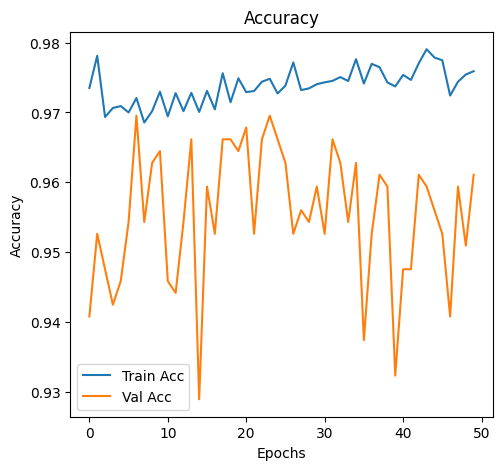

In [45]:
# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


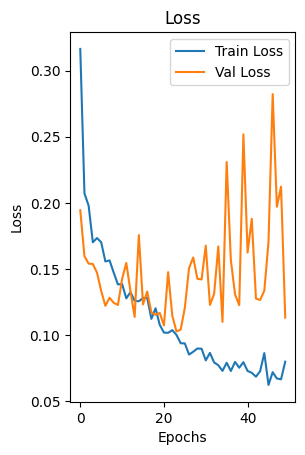

In [46]:
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()